In [6]:
import matplotlib.pyplot as plt
import numpy as np

def distr_projection(next_distr, rewards, dones,Vmin,Vmax,n_atoms, gamma):
    batch_size=len(rewards)
    proj_distr=np.zeros((batch_size, n_atoms), dtype=np.float32)
    delta_z=(Vmax-Vmin)/(n_atoms-1)
    
    for atom in range(n_atoms):
        '''
        line below makes sure that the value is with the range (Vmin,Vmax),
        if reward is out of the range, just clip it to the side
        '''
        tz_j=np.minimum(Vmax,np.maximum(Vmin,rewards+(Vmin+atom*delta_z)*gamma))
        b_j=(tz_j-Vmin)/delta_z
        l=np.floor(b_j).astype(np.int64)
        u=np.ceil(b_j).astype(np.int64)
        
        '''
        if reward falls exactly on an atom, just add to the current value
        '''
        eq_mask=u==l
        proj_distr[eq_mask,l[eq_mask]]+=next_distr[eq_mask, atom]
        
        '''
        if reward doesn't fall on any atom, 
        spread the value to the two closest atoms, by its distance to the atoms
        '''
        ne_mask=u!=l
        proj_distr[ne_mask, l[ne_mask]]+=next_distr[ne_mask, atom]*(u-b_j)[ne_mask] 
        proj_distr[ne_mask, u[ne_mask]]+=next_distr[ne_mask, atom]*(b_j-l)[ne_mask]
        
        
    '''
    if done, the reward should be on one atom
    '''
    if dones.any():
        proj_distr[dones]=0.
        tz_j=np.minimum(Vmax,np.maximum(Vmin,rewards[dones]))
        b_j=(tz_j-Vmin)/delta_z
        l=np.floor(b_j).astype(np.int64)
        u=np.ceil(b_j).astype(np.int64)
        
        eq_mask=u==l
        eq_dones=dones.copy()
        eq_dones[dones]=eq_mask
        if eq_dones.any():
            proj_distr[eq_dones,l]=1.

        ne_mask=u!=l
        ne_dones=dones.copy()
        ne_dones[dones]=ne_mask
        if ne_dones.any():
            proj_distr[ne_dones,l]=(u-b_j)[ne_mask]
            proj_distr[ne_dones,u]=(b_j-l)[ne_mask]
     
    return proj_distr

Vmax=10
Vmin=-10
N_ATOMS=51
DELTA_Z=(Vmax-Vmin)/(N_ATOMS-1)

def save_distr(src,proj,name):
    plt.clf()
    p=np.arange(Vmin,Vmax+DELTA_Z,DELTA_Z)
    plt.subplot(2,1,1)
    plt.bar(p,src,width=0.5)
    plt.title("Source")
    plt.subplot(2,1,2)
    plt.bar(p,proj,width=0.5)
    plt.title("Projected")
    plt.savefig(name+".png")

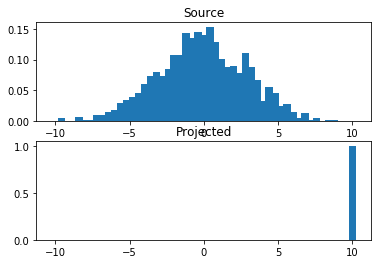

In [5]:
np.random.seed(123)
atoms=np.arange(Vmin,Vmax+DELTA_Z,DELTA_Z)

#src_hist=np.zeros(shape=(1,N_ATOMS),dtype=np.float32)
#src_hist[0,N_ATOMS//2+1]=1.0
#proj_hist=distr_projection(src_hist, np.array([2], dtype=np.float32),np.array([False]), Vmin,Vmax,N_ATOMS,gamma=0.9)
#save_distr(src_hist[0],proj_hist[0],"peak-r=2")

data=np.random.normal(size=1000,scale=3)
hist=np.histogram(data,density=True,bins=np.arange(Vmin-DELTA_Z/2,Vmax+DELTA_Z*3/2,DELTA_Z))
src_hist=hist[0]
proj_hist=distr_projection(np.array([src_hist, src_hist]), np.array([10,10],dtype=np.float32), np.array([False,True]), Vmin,Vmax,N_ATOMS,gamma=0.9)
save_distr(src_hist,proj_hist[0],"plots/both_clip-right-01-incomplete")
save_distr(src_hist,proj_hist[1],"plots/both_clip-right-02-complete")